# ⚡️Codegen: Import Loops

### Analyzing and fixing *import loops* in the Pytorch repository

This notebook demonstrates how to use the Codegen SDK to detect, analyze, and fix problematic import cycles in the official PyTorch repository. Specifically shown are the following:
1. Detect import loops
2. Visualize them
3. Identify problematic cycles with mixed static/dynamic imports
4. Fix these cycles using codegen

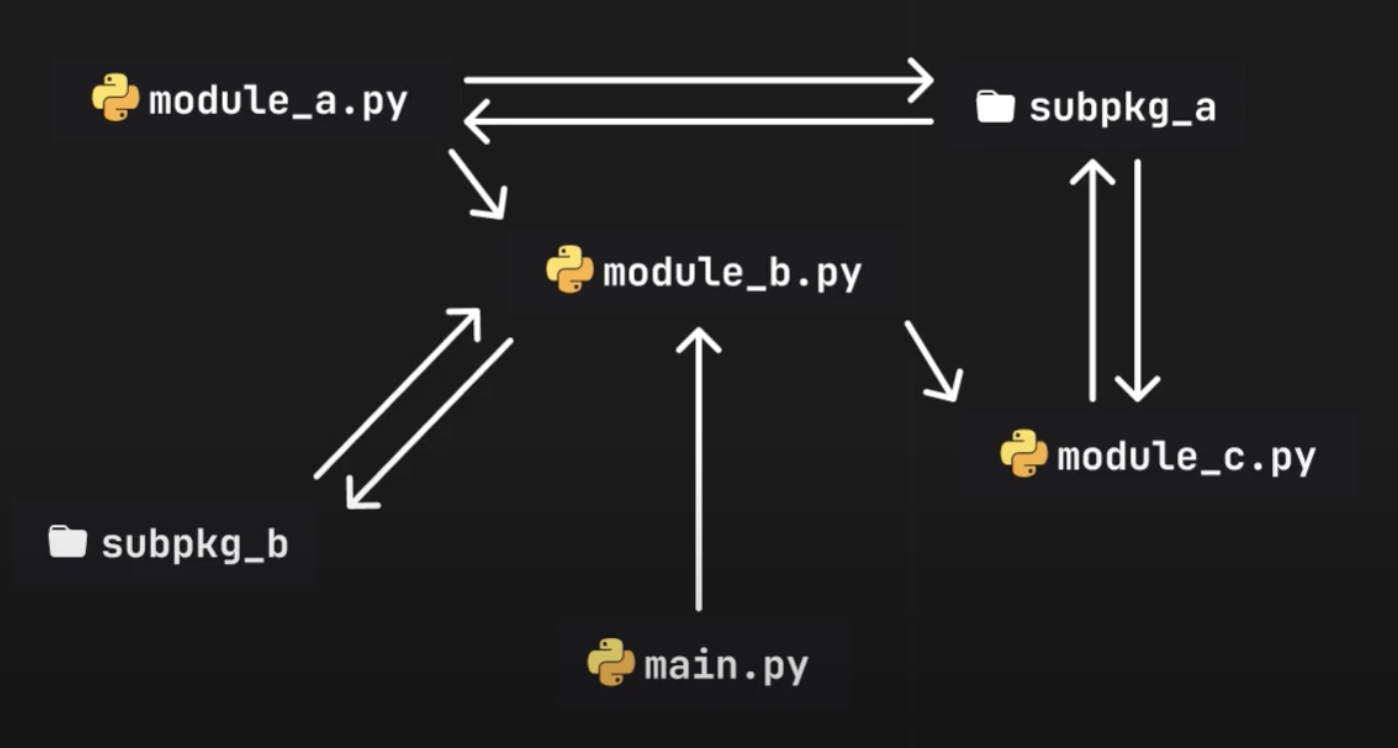

In [ ]:
!brew install graphviz
!uv pip install pygraphviz

In [ ]:
from codegen import Codebase
import networkx as nx
from utils import visualize_graph  # utility function to visualize a networkx  graph

## Loading and Parsing the Codebase

First, we'll create a Codebase object for PyTorch. The SDK will parse the entire codebase and build a graph of all imports.

In [ ]:
codebase = Codebase.from_repo("pytorch/pytorch")
# codebase = Codebase("path/to/pytorch") # uncomment this if you have pytorch cloned locally

## Finding Import Cycles

Let's find all import cycles in the codebase. The SDK detects both static and dynamic imports, marking them with different colors in the visualization:
- Red edges: Dynamic imports
- Black edges: Static imports

In [ ]:
G = nx.MultiDiGraph()

# Add all edges to the graph
for imp in codebase.imports:
    if imp.from_file and imp.to_file:
        edge_color = "red" if imp.is_dynamic else "black"
        edge_label = "dynamic" if imp.is_dynamic else "static"

        # Store the import statement and its metadata
        G.add_edge(
            imp.to_file.filepath,
            imp.from_file.filepath,
            color=edge_color,
            label=edge_label,
            is_dynamic=imp.is_dynamic,
            import_statement=imp,  # Store the whole import object
            key=id(imp.import_statement),
        )
# Find strongly connected components
cycles = [scc for scc in nx.strongly_connected_components(G) if len(scc) > 1]

print(f"🔄 Found {len(cycles)} import cycles:")
for i, cycle in enumerate(cycles, 1):
    print(f"\nCycle #{i}:")
    print(f"Size: {len(cycle)} files")

    # Create subgraph for this cycle to count edges
    cycle_subgraph = G.subgraph(cycle)

    # Count total edges
    total_edges = cycle_subgraph.number_of_edges()
    print(f"Total number of imports in cycle: {total_edges}")

    # Count dynamic and static imports separately
    dynamic_imports = sum(1 for u, v, data in cycle_subgraph.edges(data=True) if data.get("color") == "red")
    static_imports = sum(1 for u, v, data in cycle_subgraph.edges(data=True) if data.get("color") == "black")

    print(f"Number of dynamic imports: {dynamic_imports}")
    print(f"Number of static imports: {static_imports}")

In [ ]:
import_loop = cycles[0]
cycle_list = list(import_loop)


def create_single_loop_graph(cycle):
    cycle_graph = nx.MultiDiGraph()  # Changed to MultiDiGraph to support multiple edges
    cycle = list(cycle)
    for i in range(len(cycle)):
        for j in range(len(cycle)):
            # Get all edges between these nodes from original graph
            edge_data_dict = G.get_edge_data(cycle[i], cycle[j])
            if edge_data_dict:
                # For each edge between these nodes
                for edge_key, edge_data in edge_data_dict.items():
                    # Add edge with all its attributes to cycle graph
                    cycle_graph.add_edge(cycle[i], cycle[j], **edge_data)
    return cycle_graph


cycle_graph = create_single_loop_graph(cycle_list)
visualize_graph(cycle_graph)

## Understanding Valid Import Cycles
Not all import cycles are problematic! Here's an example of a cycle that one may think would break but does not because it uses dynamic imports to break the cycle at runtime.

A dynamic import is an import defined inside of a function, method or any excutable body of code which delays the import to be executed (or loaded dynamically) until that function or method is called.

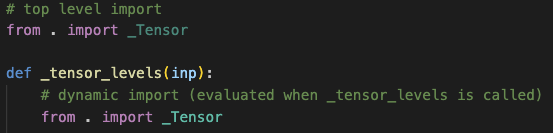

In [ ]:
cycle_graph = create_single_loop_graph(cycles[9])
visualize_graph(cycle_graph)

## Finding Problematic Import Cycles

The most concerning cycles are those where a single file has both static and dynamic imports from the same module. These are prone to runtime errors and should be refactored.

In [ ]:
def find_problematic_import_loops(G, sccs):
    """Find cycles where files have both static and dynamic imports between them."""
    problematic_cycles = []

    for i, scc in enumerate(sccs):
        if i == 2:  # skipping the second import loop as it's incredibly long (it's also invalid)
            continue
        mixed_import_files = {}  # (from_file, to_file) -> {dynamic: count, static: count}

        # Check all file pairs in the cycle
        for from_file in scc:
            for to_file in scc:
                if G.has_edge(from_file, to_file):
                    # Get all edges between these files
                    edges = G.get_edge_data(from_file, to_file)

                    # Count imports by type
                    dynamic_count = sum(1 for e in edges.values() if e["color"] == "red")
                    static_count = sum(1 for e in edges.values() if e["color"] == "black")

                    # If we have both types between same files, this is problematic
                    if dynamic_count > 0 and static_count > 0:
                        mixed_import_files[(from_file, to_file)] = {"dynamic": dynamic_count, "static": static_count, "edges": edges}

        if mixed_import_files:
            problematic_cycles.append({"files": scc, "mixed_imports": mixed_import_files, "index": i})

    # Print findings
    print(f"Found {len(problematic_cycles)} cycles with mixed imports:")
    for i, cycle in enumerate(problematic_cycles):
        print(f"\n⚠️  Problematic Cycle #{i + 1}:")
        print(f"\n⚠️  Index #{cycle['index']}:")
        print(f"Size: {len(cycle['files'])} files")

        for (from_file, to_file), data in cycle["mixed_imports"].items():
            print("\n📁 Mixed imports detected:")
            print(f"  From: {from_file}")
            print(f"  To:   {to_file}")
            print(f"  Dynamic imports: {data['dynamic']}")
            print(f"  Static imports: {data['static']}")

    return problematic_cycles


problematic_loops = find_problematic_import_loops(G, cycles)

In [ ]:
# analyze the import loop
cycle_graph = create_single_loop_graph(cycles[11])
visualize_graph(cycle_graph)

In `flex_decoding.py` there are two import statments from `flex_attention.py`

Having mixed import types (dynamic and static) that are also a part of a closed import loop are problematic and may cause errors.

#### Static
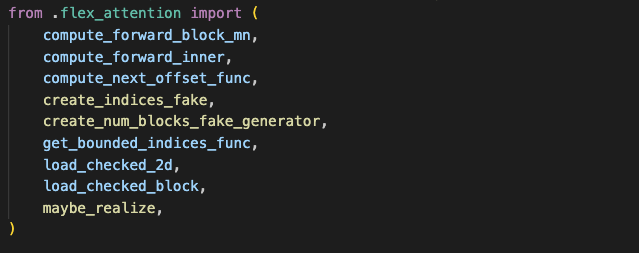

#### Dynamic
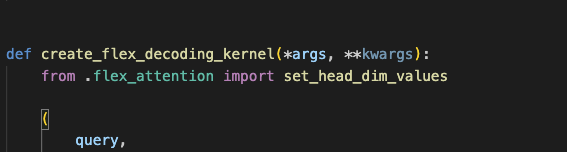

## Fixing Problematic Cycles

When we find a problematic cycle, a common fix is to move the shared code to a new utility module. We can use codegen to perform this refactor.

In [ ]:
# Create new utils file
utils_file = codebase.create_file("torch/_inductor/kernel/flex_utils.py")

# Get the two files involved in the import cycle
decoding_file = codebase.get_file("torch/_inductor/kernel/flex_decoding.py")
attention_file = codebase.get_file("torch/_inductor/kernel/flex_attention.py")
attention_file_path = "torch/_inductor/kernel/flex_attention.py"
decoding_file_path = "torch/_inductor/kernel/flex_decoding.py"

# Track symbols to move
symbols_to_move = set()

# Find imports from flex_attention in flex_decoding
for imp in decoding_file.imports:
    if imp.from_file and imp.from_file.filepath == attention_file_path:
        # Get the actual symbol from flex_attention
        if imp.imported_symbol:
            symbols_to_move.add(imp.imported_symbol)

# Move identified symbols to utils file
for symbol in symbols_to_move:
    symbol.move_to_file(utils_file)

print(f"🔄 Moved {len(symbols_to_move)} symbols to flex_utils.py")
for symbol in symbols_to_move:
    print(symbol.name)

In [ ]:
# run this command to have the changes take effect in the codebase
codebase.commit()

### Resulting Diffs

- ```flex_decoding.py```: Update imports from .flex_attention to .flex_utils

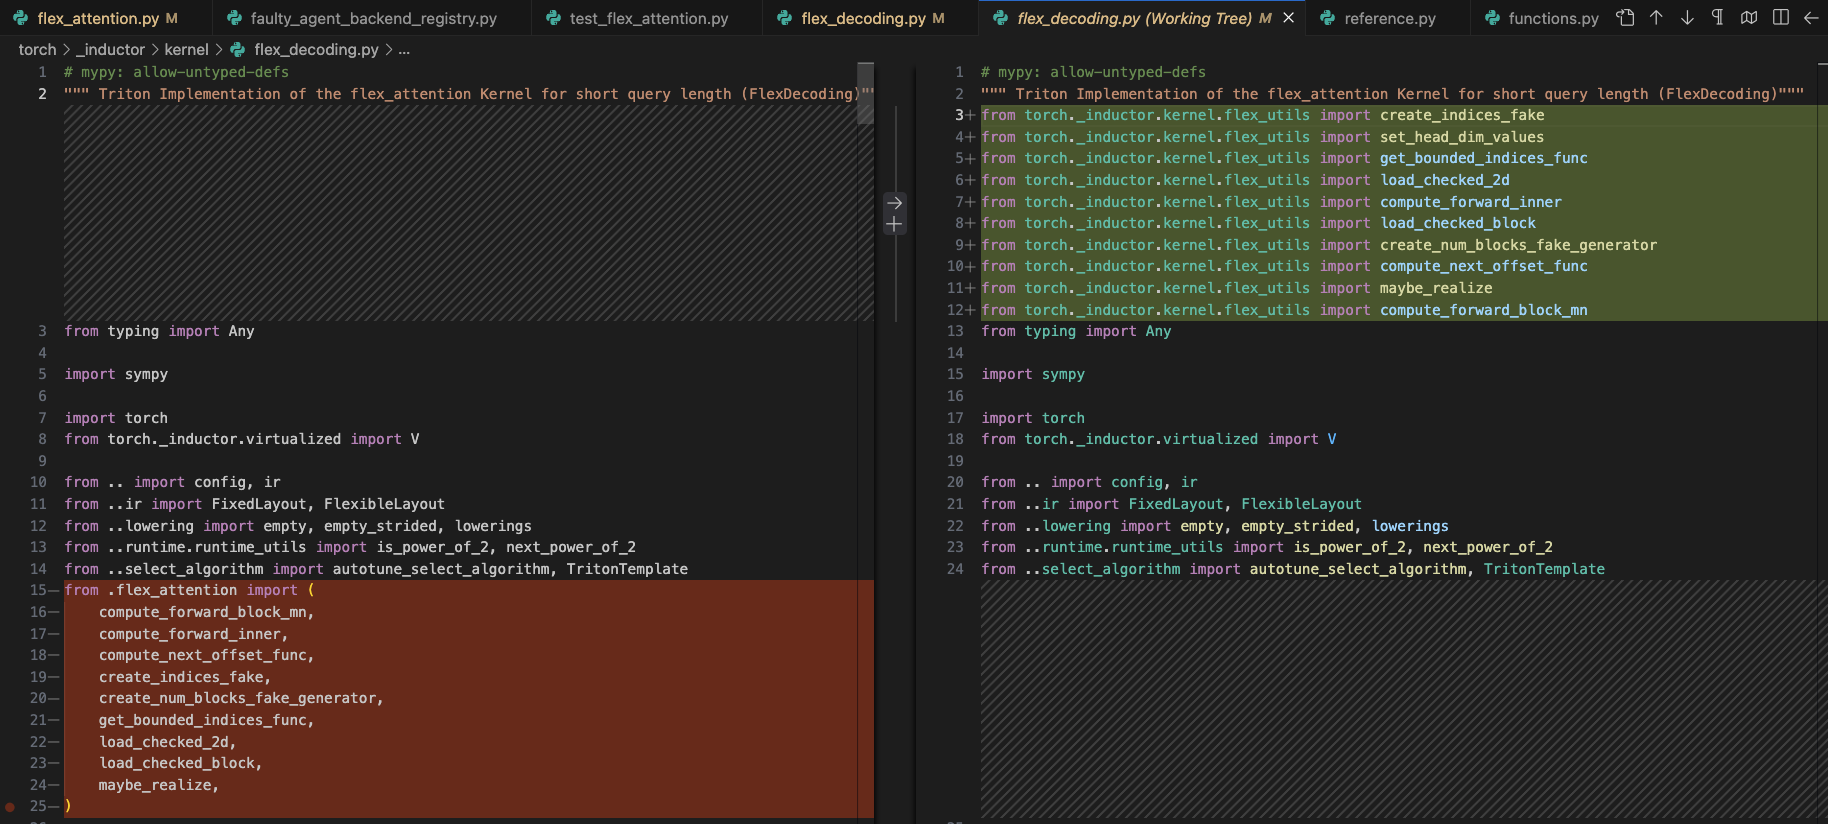

- ```flex_attention.py```: Adds imports from .flex_utils

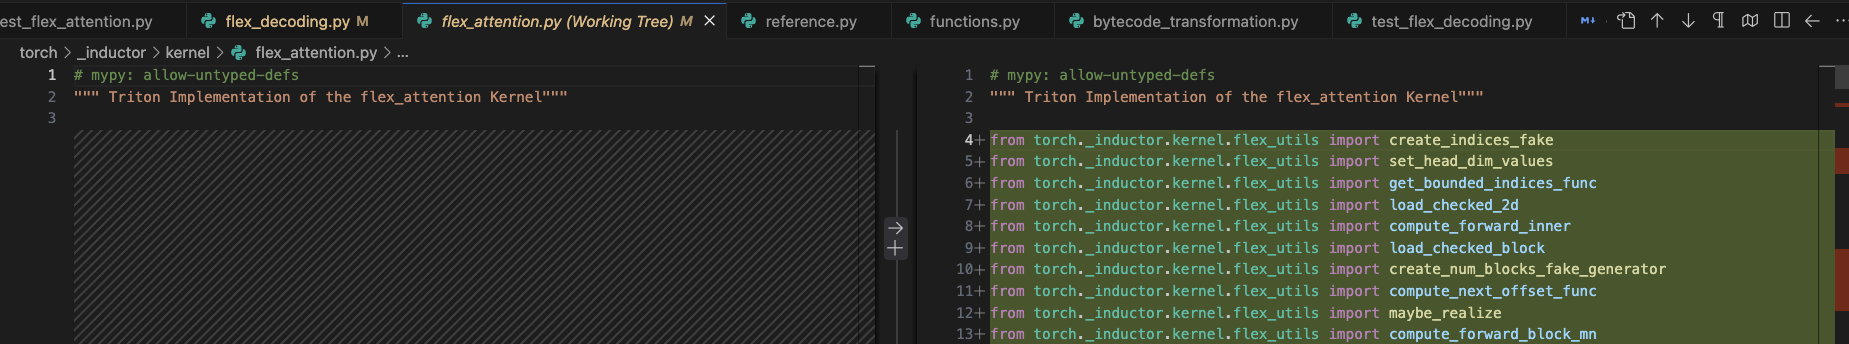

- ```flex_utils.py```: Move shared symbols for flex_decoding and flex_attention

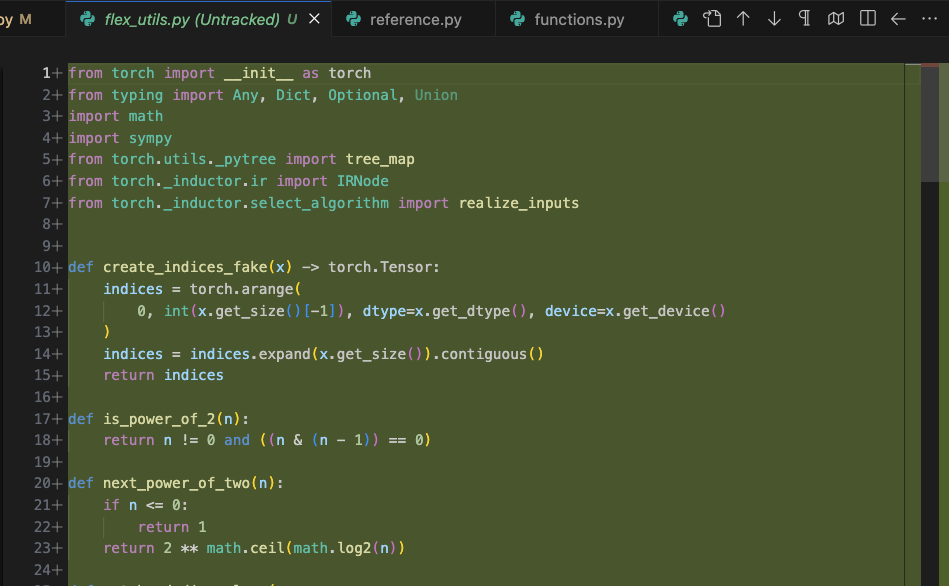

## Conclusion

Using the Codegen SDK, we can:
1. Automatically detect import cycles in large codebases
2. Visualize them to understand their structure
3. Identify problematic patterns like mixed static/dynamic imports
4. Automatically refactor code to fix these issues

This helps maintain a healthy codebase by preventing import-related bugs before they occur in production.